In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade transformers

In [3]:
!pip install transformers torch datasets scikit-learn pandas numpy seaborn matplotlib lime

In [4]:
!pip install numpy==1.26.4

In [5]:
# ======================
# 0. Import & Config
# ======================

import os
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

from lime.lime_text import LimeTextExplainer

DATA_FAKE_PATH = "/content/drive/MyDrive/Data-Raws/fake_news.csv"
DATA_TRUE_PATH = "/content/drive/MyDrive/Data-Raws/true_news.csv"
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 128
RANDOM_SEED = 42
N_SPLITS = 3  # k-fold

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# ======================
# 1. Load & Cleaning
# ======================

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

fake_df = pd.read_csv(DATA_FAKE_PATH)
true_df = pd.read_csv(DATA_TRUE_PATH)

fake_df["full_text"] = (fake_df["title"].fillna("") + " " + fake_df["text"].fillna("")).apply(clean_text)
true_df["full_text"] = (true_df["title"].fillna("") + " " + true_df["text"].fillna("")).apply(clean_text)

fake_df["label"] = 1
true_df["label"] = 0

df = pd.concat(
    [fake_df[["full_text", "label"]], true_df[["full_text", "label"]]],
    axis=0
).reset_index(drop=True)

df = df[df["full_text"].str.len() > 0].reset_index(drop=True)

print(df.head())
print("Total samples:", len(df))

                                           full_text  label
0  Donald Trump Sends Out Embarrassing New Year’s...      1
1  Drunk Bragging Trump Staffer Started Russian C...      1
2  Sheriff David Clarke Becomes An Internet Joke ...      1
3  Trump Is So Obsessed He Even Has Obama’s Name ...      1
4  Pope Francis Just Called Out Donald Trump Duri...      1
Total samples: 44889


Label distribution:
label
1    23472
0    21417
Name: count, dtype: int64

Label ratio:
label
1    0.52289
0    0.47711
Name: proportion, dtype: float64

Text length statistics:
count    44889.000000
mean       417.691149
std        351.431566
min          4.000000
25%        216.000000
50%        375.000000
75%        526.000000
max       8148.000000
Name: text_len, dtype: float64


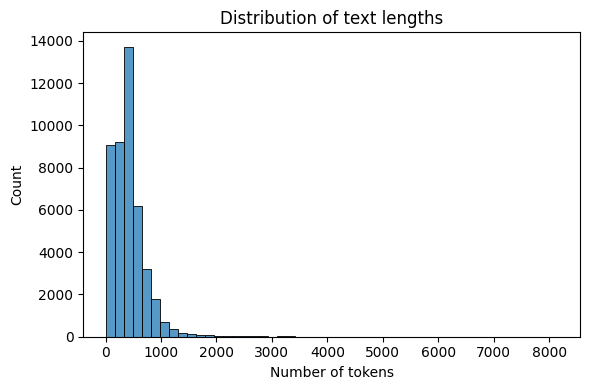

In [7]:
# ======================
# 2. EDA
# ======================

print("Label distribution:")
print(df["label"].value_counts())
print("\nLabel ratio:")
print(df["label"].value_counts(normalize=True))

df["text_len"] = df["full_text"].str.split().apply(len)
print("\nText length statistics:")
print(df["text_len"].describe())

plt.figure(figsize=(6, 4))
sns.histplot(df["text_len"], bins=50)
plt.title("Distribution of text lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.tight_layout()

# Hiển thị trực tiếp trong notebook
plt.show()

In [8]:
# ======================
# 3. Tokenizer & Dataset
# ======================

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(label)
        return item

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
# ======================
# 4. Metrics function
# ======================

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [10]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [11]:
# ======================
# 5. K-FOLD CROSS VALIDATION (TỐI ƯU)
# ======================

X = df["full_text"].values
y = df["label"].values

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
fold_metrics = []

fold_id = 1
for train_idx, val_idx in skf.split(X, y):

    print(f"\n--- Fold {fold_id}/{N_SPLITS} ---")

    train_dataset = FakeNewsDataset(X[train_idx], y[train_idx], tokenizer, MAX_LENGTH)
    val_dataset   = FakeNewsDataset(X[val_idx], y[val_idx], tokenizer, MAX_LENGTH)

    fold_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=2
    ).to(device)

    training_args = TrainingArguments(
        output_dir=f"./distilbert_fold_{fold_id}",
        num_train_epochs=1,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        fp16=True,
        learning_rate=3e-5,
        weight_decay=0.01,
        logging_steps=50,
        logging_dir=f"./logs_fold_{fold_id}",
    )

    trainer = Trainer(
        model=fold_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    eval_results = trainer.predict(val_dataset)
    metrics = compute_metrics((eval_results.predictions, eval_results.label_ids))
    print(metrics)

    fold_metrics.append(metrics)
    fold_id += 1


--- Fold 1/3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.208300
100,0.024800
150,0.008100
200,0.024800
250,0.000800
300,0.009300
350,0.001300
400,0.002100
450,0.023600
500,0.009900


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.9993985163403061, 'precision': 0.9988510149368058, 'recall': 1.0, 'f1': 0.9994251772370186}

--- Fold 2/3 ---


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.261500
100,0.012200
150,0.008900
200,0.001100
250,0.007300
300,0.008500
350,0.000400
400,0.011100
450,0.005300
500,0.000300


{'accuracy': 0.9997326739290249, 'precision': 0.9996166624073601, 'recall': 0.9998721881390593, 'f1': 0.999744408945687}

--- Fold 3/3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.240600
100,0.003700
150,0.013300
200,0.032200
250,0.001000
300,0.000600
350,0.006000
400,0.010500
450,0.008900
500,0.000300


{'accuracy': 0.9991311902693311, 'precision': 0.9988504278962831, 'recall': 0.9994887525562373, 'f1': 0.9991694882770076}


In [12]:
# ======================
# 6. K-FOLD SUMMARY
# ======================

print("\n=== Cross-Validation Summary ===")
for m in fold_metrics[0].keys():
    scores = [f[m] for f in fold_metrics]
    print(f"{m}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


=== Cross-Validation Summary ===
accuracy: 0.9994 ± 0.0002
precision: 0.9991 ± 0.0004
recall: 0.9998 ± 0.0002
f1: 0.9994 ± 0.0002


In [13]:
import transformers
transformers.__version__

'4.57.1'

In [14]:
# ======================
# 7. TRAIN FINAL MODEL (TỐI ƯU)
# ======================

X_train_full, X_test_holdout, y_train_full, y_test_holdout = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=RANDOM_SEED
)

train_full_dataset = FakeNewsDataset(X_train_full, y_train_full, tokenizer, MAX_LENGTH)
test_holdout_dataset = FakeNewsDataset(X_test_holdout, y_test_holdout, tokenizer, MAX_LENGTH)

final_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(device)

final_args = TrainingArguments(
    output_dir="./distilbert_final",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    fp16=True,
    learning_rate=3e-5,
    weight_decay=0.01,

    eval_strategy="epoch",
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="f1",

    logging_steps=50,
    report_to=[]
)

final_trainer = Trainer(
    model=final_model,
    args=final_args,
    train_dataset=train_full_dataset,
    eval_dataset=test_holdout_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

final_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000400,0.002882,0.999554,0.999149,1.000000,0.999574
2,0.010500,0.007354,0.998441,0.999573,0.997444,0.998507
3,0.000000,0.002205,0.999777,0.999574,1.000000,0.999787


TrainOutput(global_step=7575, training_loss=0.0042630882969390445, metrics={'train_runtime': 916.7652, 'train_samples_per_second': 132.204, 'train_steps_per_second': 8.263, 'total_flos': 4013762179276800.0, 'train_loss': 0.0042630882969390445, 'epoch': 3.0})


Final Hold-Out Performance:
Accuracy : 0.9998
Precision: 0.9996
Recall   : 1.0000
F1-score : 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2142
           1       1.00      1.00      1.00      2347

    accuracy                           1.00      4489
   macro avg       1.00      1.00      1.00      4489
weighted avg       1.00      1.00      1.00      4489



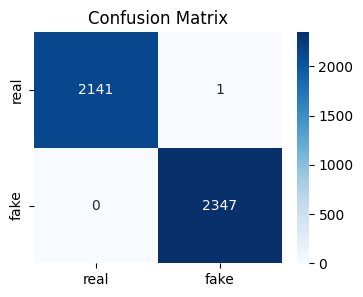

Model saved!


In [15]:
# ======================
# 8. EVALUATION OF FINAL MODEL
# ======================

test_results = final_trainer.predict(test_holdout_dataset)
logits = test_results.predictions
labels = test_results.label_ids
preds = np.argmax(logits, axis=-1)

acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

print("\nFinal Hold-Out Performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(labels, preds))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["real","fake"], yticklabels=["real","fake"])
plt.title("Confusion Matrix")
plt.show()

final_model.save_pretrained("./distilbert_final")
tokenizer.save_pretrained("./distilbert_final")

print("Model saved!")

In [16]:
# ======================
# 9. INFERENCE + LIME EXPLAINABILITY
# ======================

class_names = ["real", "fake"]
explainer = LimeTextExplainer(class_names=class_names)

def predict_single(text):
    final_model.eval()
    with torch.no_grad():
        enc = tokenizer(text, truncation=True, padding="max_length",
                        max_length=MAX_LENGTH, return_tensors="pt")
        enc = {k: v.to(device) for k,v in enc.items()}
        outputs = final_model(**enc)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
    return {"label": class_names[pred], "real_prob": float(probs[0]), "fake_prob": float(probs[1])}

def lime_predict_proba(texts):
    final_model.eval()
    probs_list = []
    for t in texts:
        with torch.no_grad():
            enc = tokenizer(t, truncation=True, padding="max_length",
                            max_length=MAX_LENGTH, return_tensors="pt")
            enc = {k: v.to(device) for k,v in enc.items()}
            out = final_model(**enc)
            probs_list.append(torch.softmax(out.logits, dim=-1).cpu().numpy()[0])
    return np.array(probs_list)

def explain_prediction(text, num_features=10):
    pred = predict_single(text)
    print("Prediction:", pred)

    exp = explainer.explain_instance(
        text_instance=text,
        classifier_fn=lime_predict_proba,
        num_features=num_features,
        labels=[0,1]
    )

    print("\nWords pushing → FAKE:")
    for w, weight in exp.as_list(label=1):
        print(f"{w:20s} {weight:.4f}")

    print("\nWords pushing → REAL:")
    for w, weight in exp.as_list(label=0):
        print(f"{w:20s} {weight:.4f}")

In [17]:
# ======================
# 10. Example test
# ======================

sample = df["full_text"].iloc[13]
print(predict_single(sample))
explain_prediction(sample)

{'label': 'fake', 'real_prob': 7.889262633398175e-06, 'fake_prob': 0.9999921321868896}
Prediction: {'label': 'fake', 'real_prob': 7.889262633398175e-06, 'fake_prob': 0.9999921321868896}

Words pushing → FAKE:
t                    0.0008
Trashes              0.0008
they                 0.0008
Trump                0.0008
has                  0.0008
Kooky                0.0008
as                   0.0007
about                0.0007
know                 0.0007
17                   0.0003

Words pushing → REAL:
t                    -0.0008
Trashes              -0.0008
they                 -0.0008
Trump                -0.0008
has                  -0.0008
Kooky                -0.0008
as                   -0.0007
about                -0.0007
know                 -0.0007
17                   -0.0003


In [28]:
import random

# ======================
# 1. Lấy mẫu ngẫu nhiên
# ======================
idx = random.randint(0, len(df) - 1)
sample_text = df["full_text"].iloc[idx]
true_label = df["label"].iloc[idx]

print(f"==== SAMPLE INDEX: {idx} ====")
print("TRUE LABEL:", "real" if true_label == 0 else "fake")
print("\nTEXT:\n", sample_text)

# ======================
# 2. Mô hình dự đoán
# ======================
pred = predict_single(sample_text)
print("\nMODEL PREDICTION:", pred)

# ======================
# 3. Giải thích bằng LIME
# ======================
explain_prediction(sample_text)

==== SAMPLE INDEX: 41905 ====
TRUE LABEL: real

TEXT:
 Spanish court grants U.S. extradition for Russian hacking suspect MADRID (Reuters) - Spain s High Court said on Tuesday it had granted a U.S. request to extradite Russian citizen Peter Levashov, who is accused of U.S. hacking offences including operating a network of infected computers used by cyber criminals. Levashov, 36, was arrested while on holiday in Barcelona in April. U.S. prosecutors have accused him of running the Kelihos botnet, a network of more than 100,000 infected devices used by cyber criminals to distribute viruses, ransomware, phishing emails and other spam attacks. U.S. prosecutors are seeking a 52-year jail sentence against Levashov, who denies the charges against him. The Spanish court said Levashov had three days to lodge an appeal against the extradition decision. Levashov, who is fighting extradition, told the Madrid court last week that he had worked for President Vladimir Putin s United Russia party for th